In [1]:
import sys
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor

In [2]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    train_and_evaluate_models,
    create_eui_comparison_plots,
    evaluate_model_strategies,
    calculate_average_metrics,
    create_error_distribution_plots
)

In [3]:
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

np.random.seed(123)
merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

In [4]:
features = [
    "hdd_total_year", 
    "cdd_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index"
]

feature_abbreviations = {
    "hdd_total_year": "HDD",
    "cdd_total_year": "CDD", 
    "GDP_per_capita": "GDP",
    "Urbanization_Rate_2022": "URB",
    "latitude": "Lat",
    "longitude": "Long",
    "Paris_Agreement": "Paris",
    "Subnational HDI": "HDI", 
    "Educational index": "EDU" , 
    "Income index": "Income"
}

target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']


# CatBoost

In [5]:
# CatBoost parameters
cat_params = {
    'iterations': 100,
    'depth': 6,
    'learning_rate': 0.1,
    'loss_function': 'RMSE',
    'verbose': False,
    'random_seed': 42,
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 20,
    'subsample': 0.8,
    'colsample_bylevel': 0.8,
    'l2_leaf_reg': 3,
    'bootstrap_type': 'Bernoulli'
}

### CatBoost - Within Domain

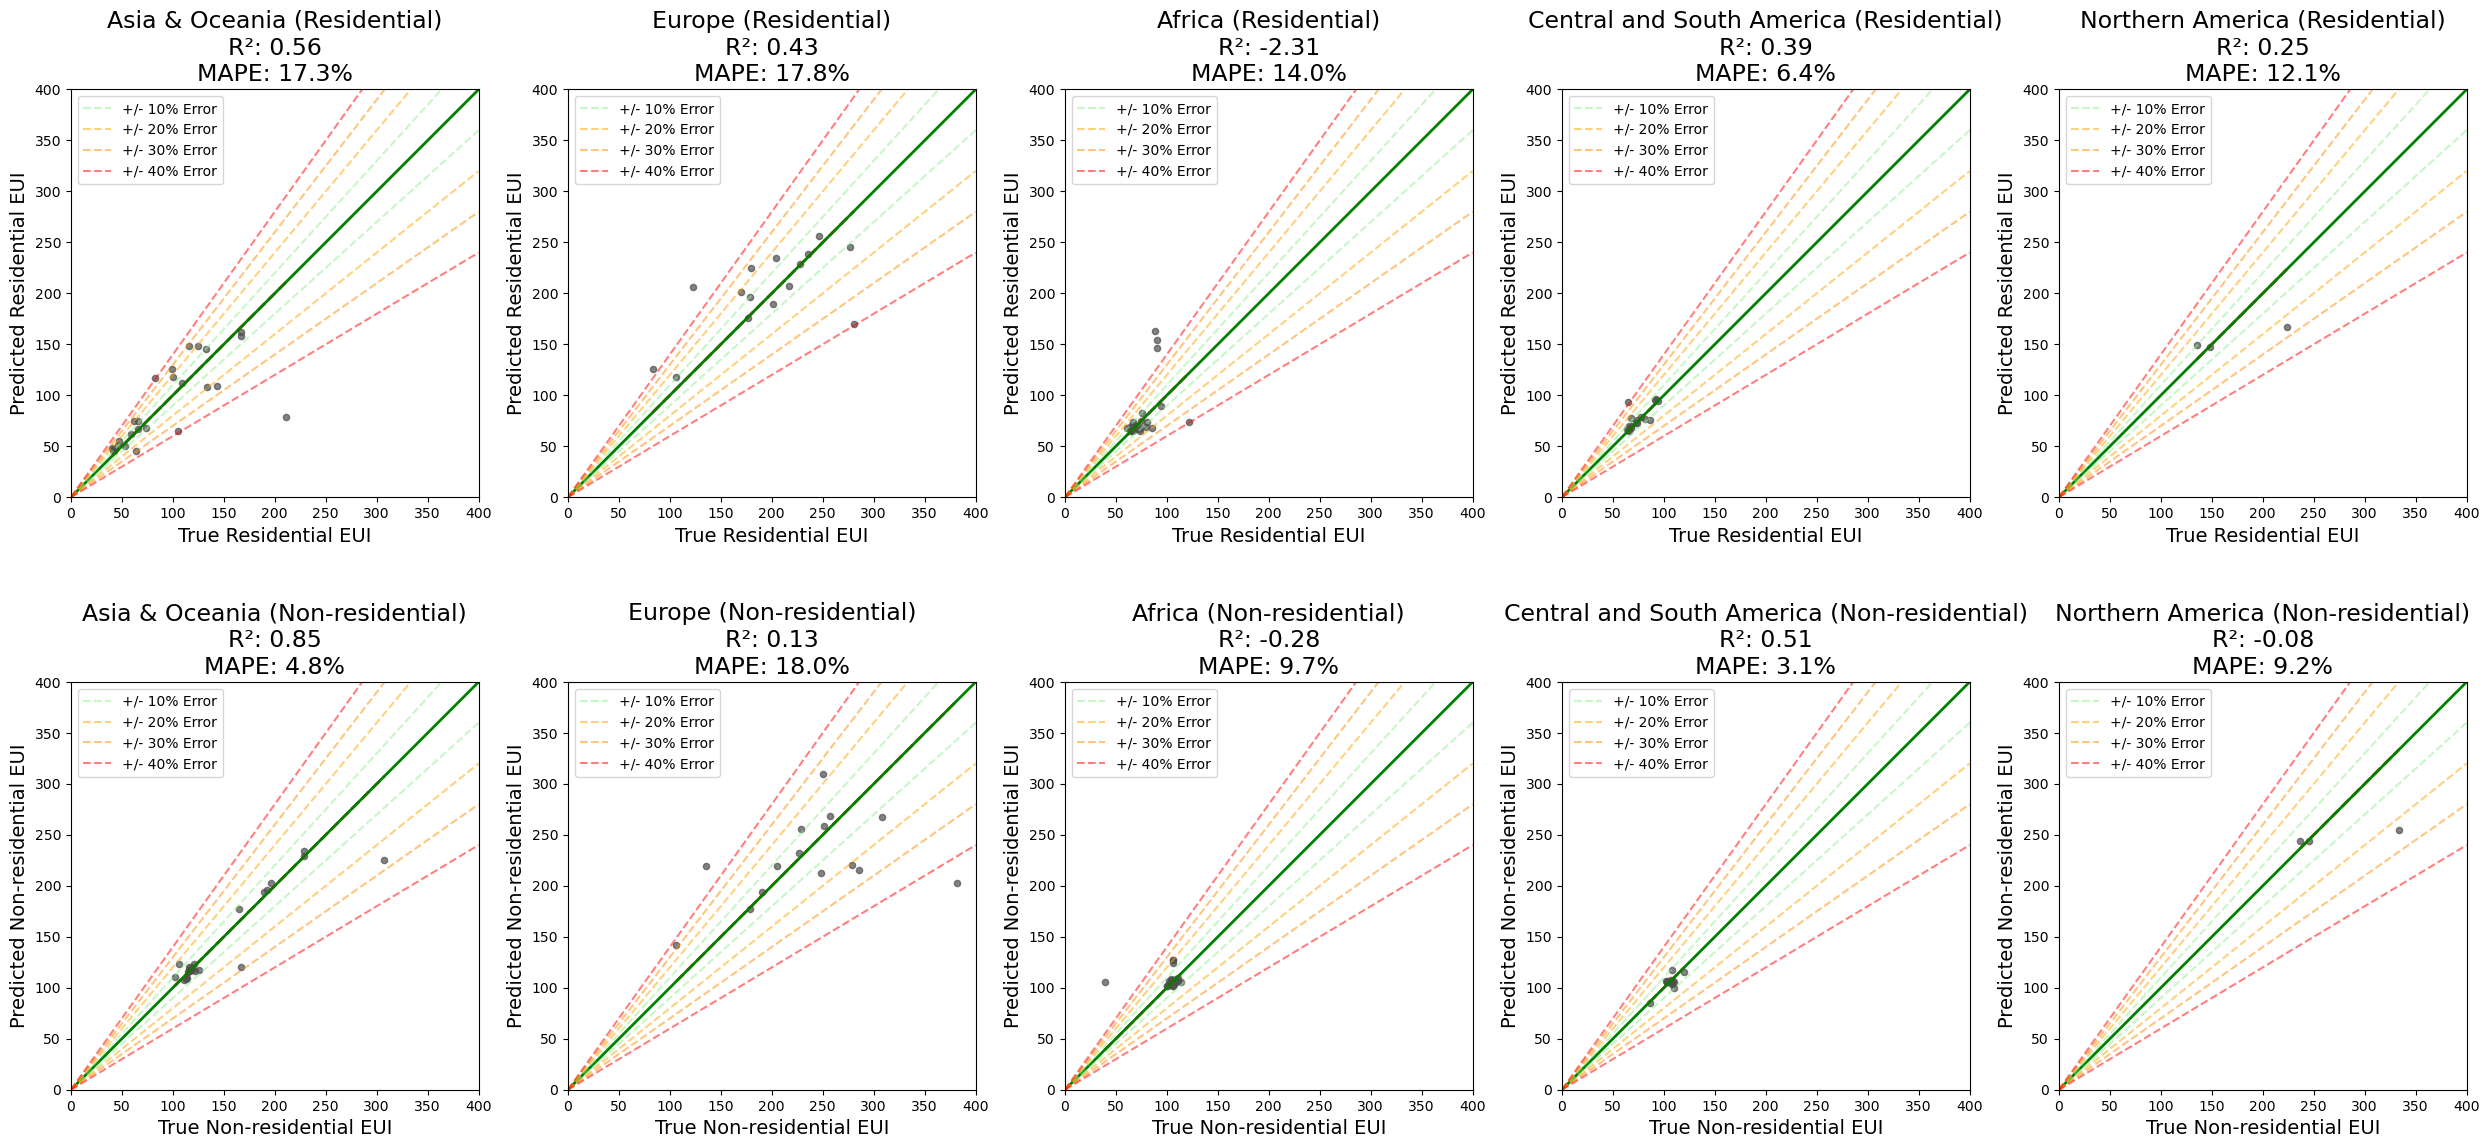

In [6]:
# Within Domain
model_cat_within = CatBoostRegressor(**cat_params)
results_cat_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_cat_within,
    strategy='within_domain'
)

create_eui_comparison_plots(results_cat_within, 
    save_path='../figures/model_plots/cat_within_domain_eui_predictions.png')

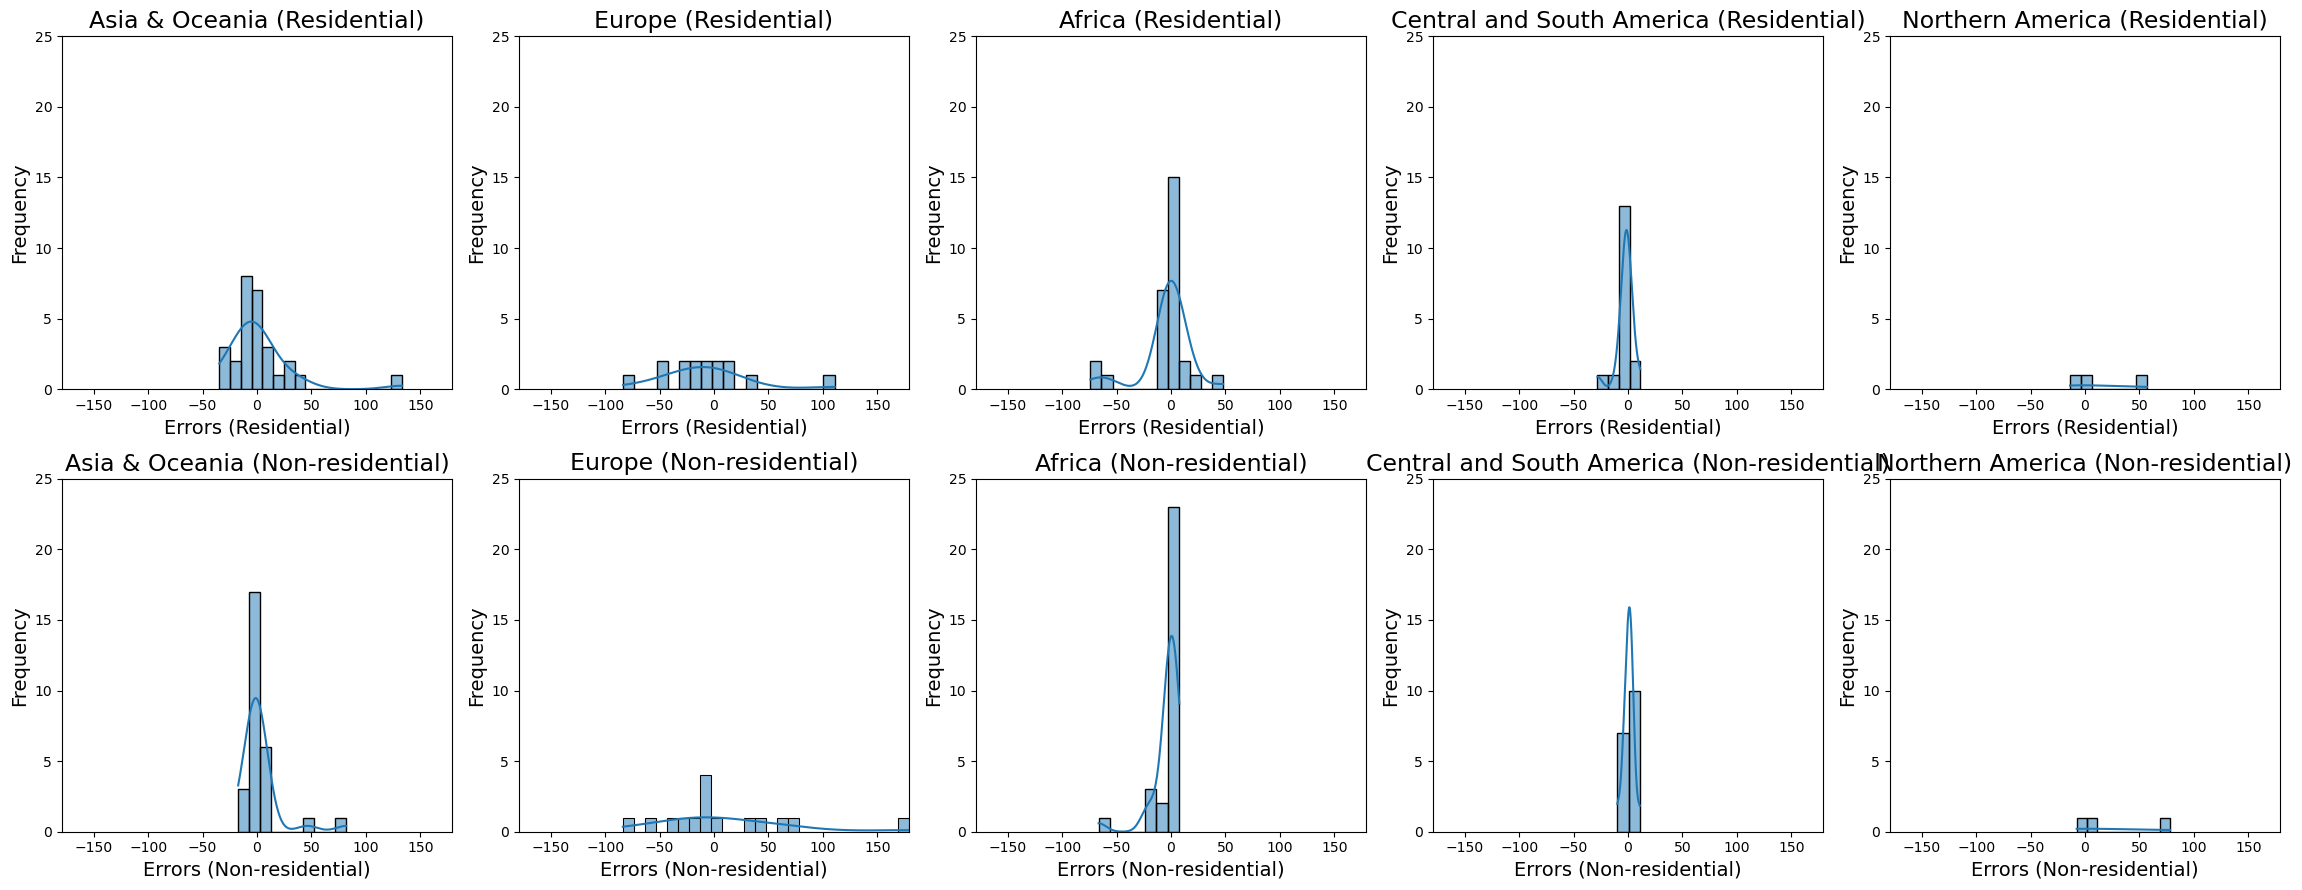

In [7]:
create_error_distribution_plots(results_cat_within,
    save_path='../figures/model_plots/cat_within_domain_error_distribution.png')


### CatBoost - Cross Domain

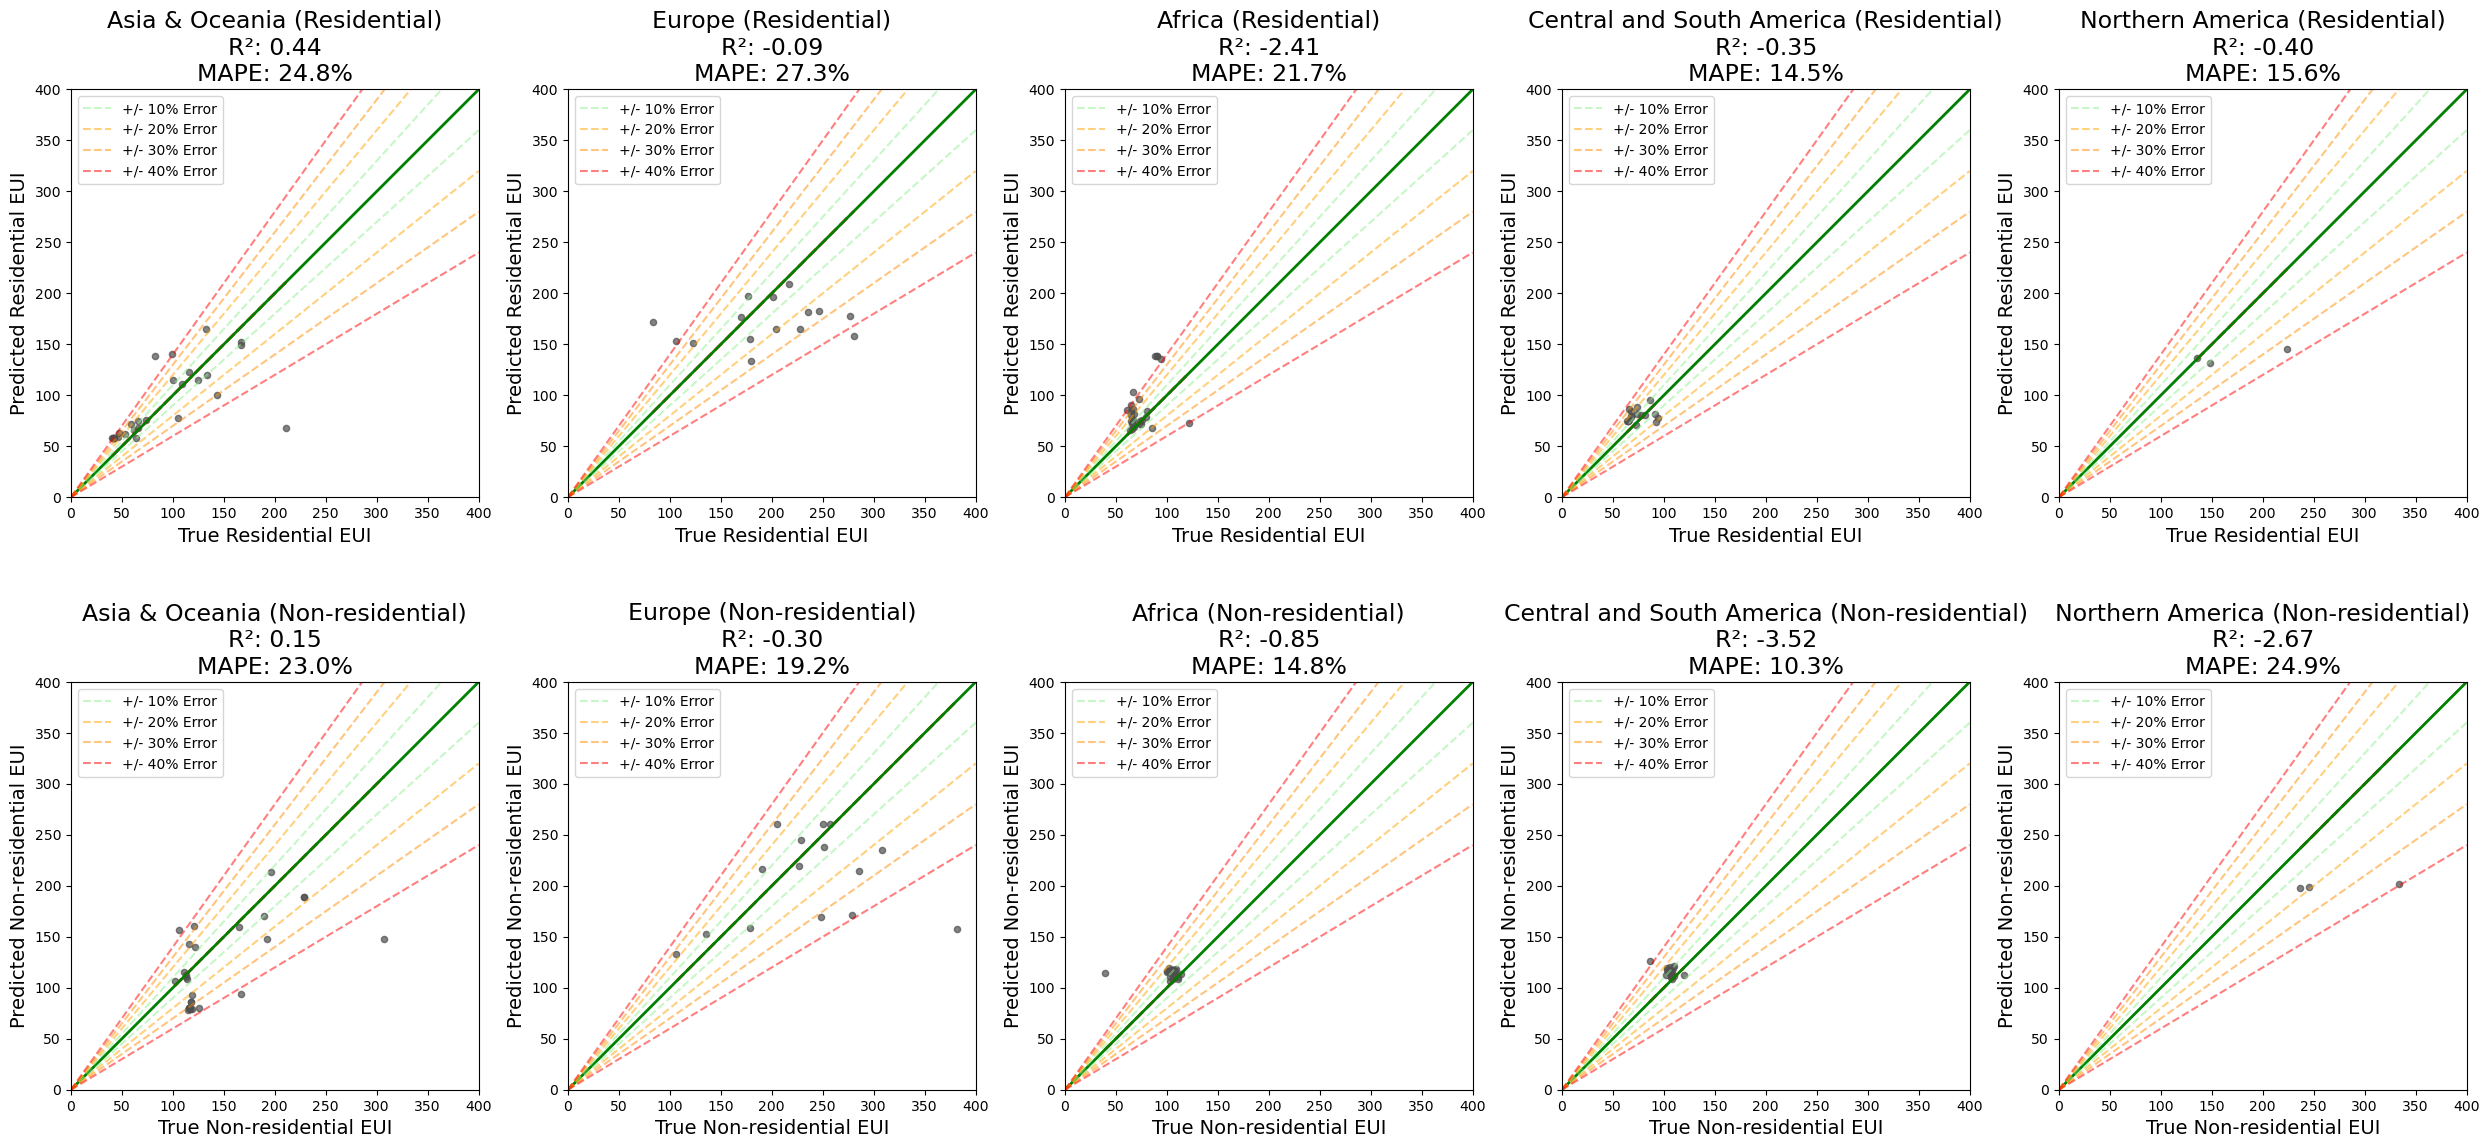

In [8]:
# Cross-domain
model_cat_cross = CatBoostRegressor(**cat_params)
results_cat_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_cat_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(results_cat_cross,
    save_path='../figures/model_plots/cat_cross_domain_eui_predictions.png')


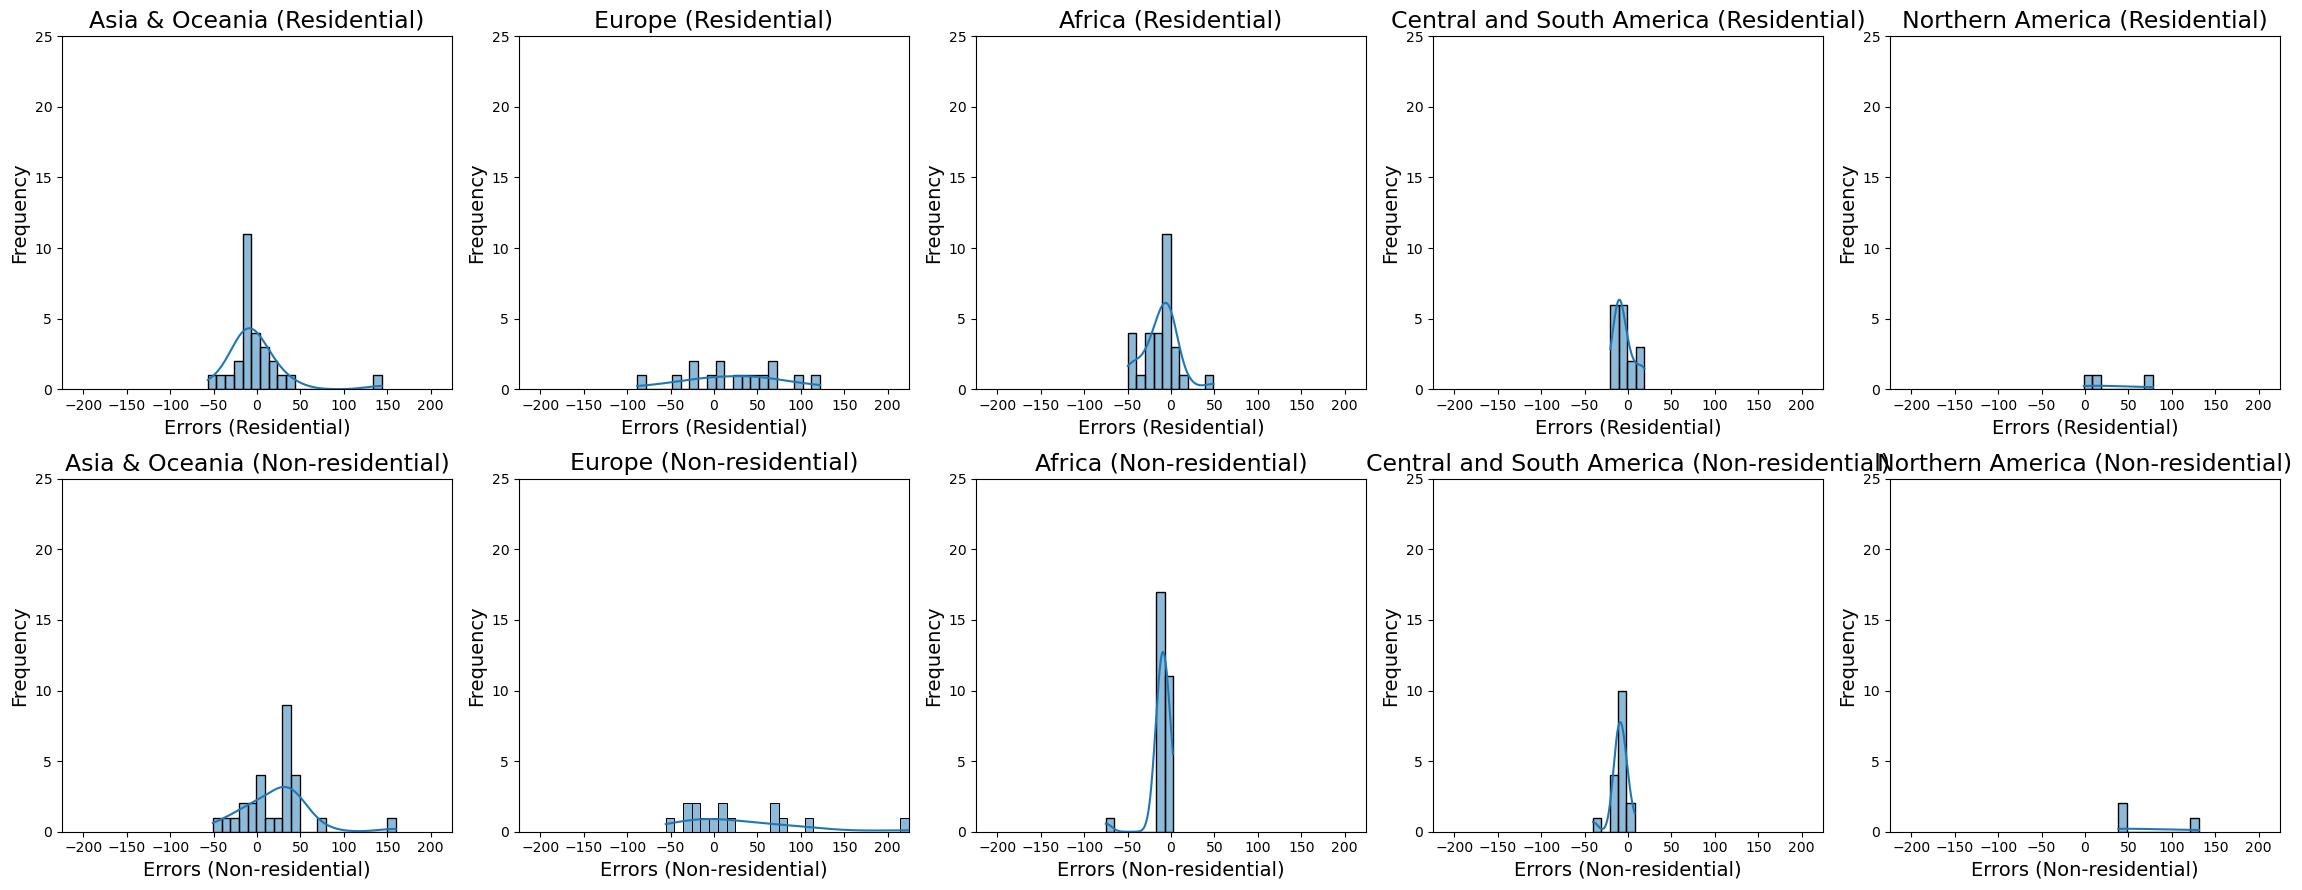

In [9]:
create_error_distribution_plots(results_cat_cross,
    save_path='../figures/model_plots/cat_cross_domain_error_distribution.png')

### CatBoost - All Domain

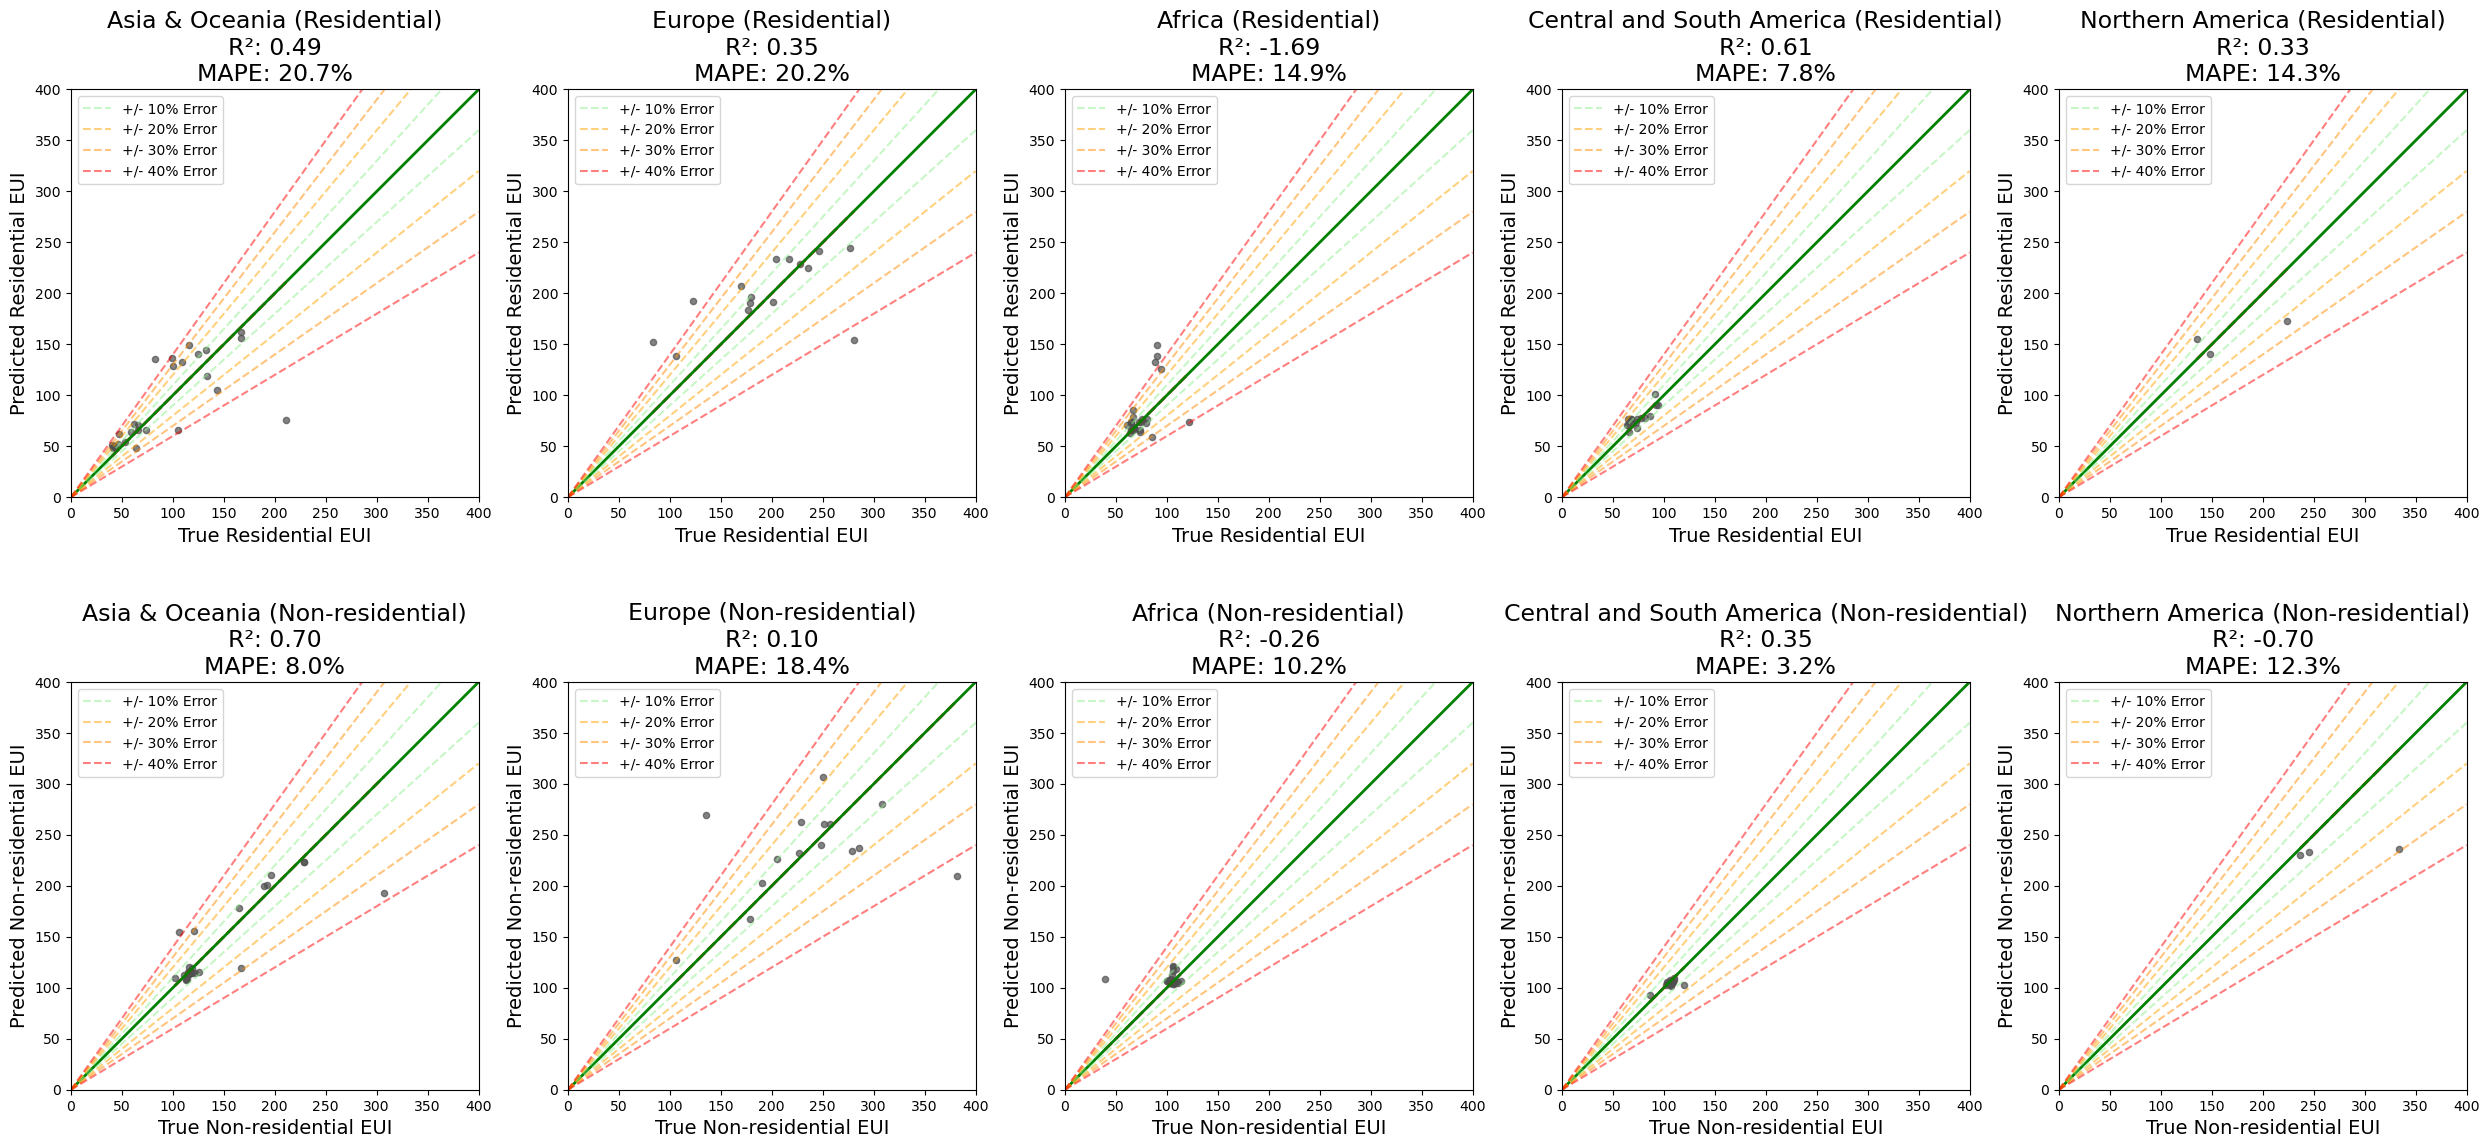

In [10]:
# All-domain
model_cat_all = CatBoostRegressor(**cat_params)
results_cat_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_cat_all,
    strategy='all_domain'
)

create_eui_comparison_plots(results_cat_all,
    save_path='../figures/model_plots/cat_all_domain_eui_predictions.png')

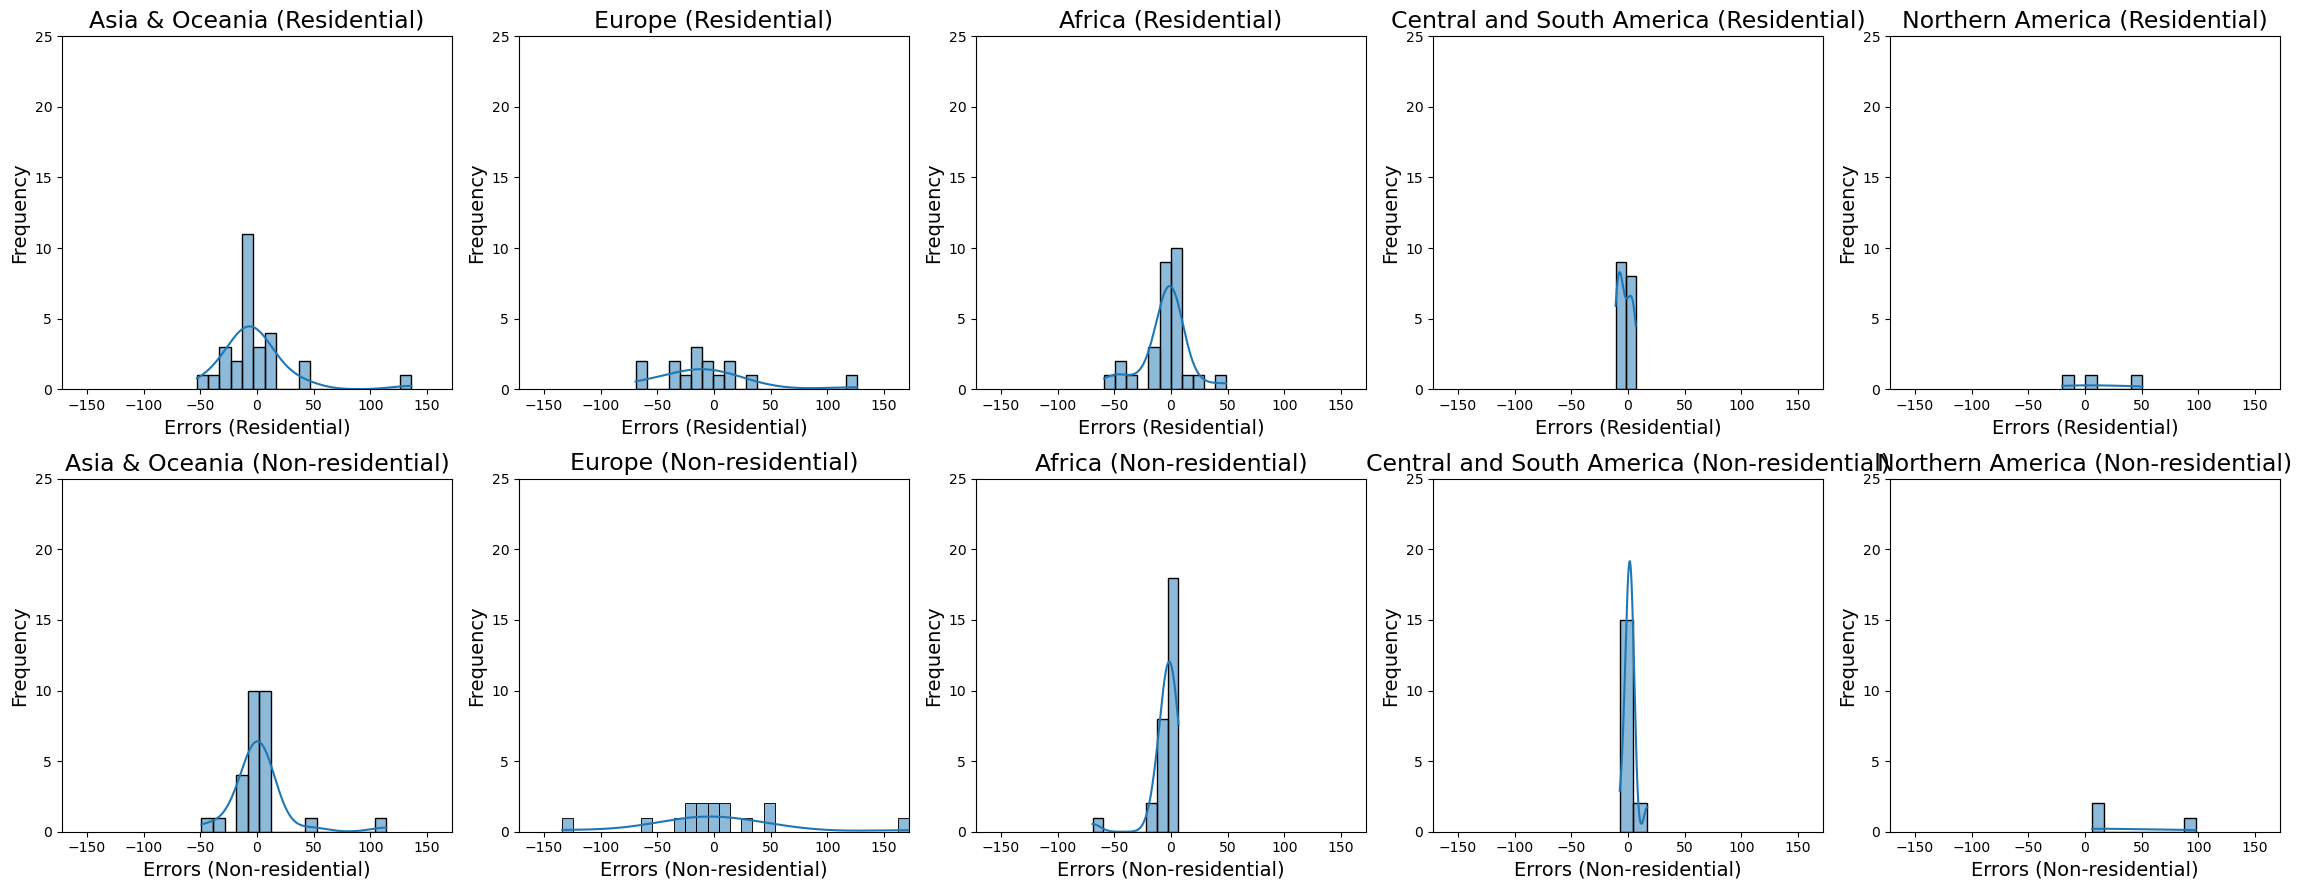

In [11]:
create_error_distribution_plots(results_cat_all,
    save_path='../figures/model_plots/cat_all_domain_error_distribution.png')

In [12]:
cat_detailed_results = evaluate_model_strategies(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_type=CatBoostRegressor,
    feature_abbreviations=feature_abbreviations,
    model_details=", ".join(f"{k} = {v}" for k, v in cat_params.items())
)

cat_average_results = calculate_average_metrics(cat_detailed_results).reset_index()
cat_average_results

Learning rate set to 0.030371
0:	learn: 59.1421749	total: 1.99ms	remaining: 1.99s
1:	learn: 58.3064524	total: 7.27ms	remaining: 3.63s
2:	learn: 57.4564837	total: 12.4ms	remaining: 4.13s
3:	learn: 56.8221624	total: 24ms	remaining: 5.99s
4:	learn: 56.0456743	total: 24.6ms	remaining: 4.88s
5:	learn: 55.2992430	total: 25.8ms	remaining: 4.27s
6:	learn: 54.5835468	total: 26.1ms	remaining: 3.71s
7:	learn: 54.0019246	total: 26.6ms	remaining: 3.29s
8:	learn: 53.2475807	total: 27.2ms	remaining: 3s
9:	learn: 52.4888839	total: 28.7ms	remaining: 2.84s
10:	learn: 51.8659102	total: 33.1ms	remaining: 2.97s
11:	learn: 51.2899894	total: 33.8ms	remaining: 2.78s
12:	learn: 50.6141765	total: 34.2ms	remaining: 2.6s
13:	learn: 50.0200515	total: 34.7ms	remaining: 2.44s
14:	learn: 49.4380643	total: 35.1ms	remaining: 2.3s
15:	learn: 48.8021846	total: 35.5ms	remaining: 2.18s
16:	learn: 48.1747723	total: 36ms	remaining: 2.08s
17:	learn: 47.5016131	total: 36.5ms	remaining: 1.99s
18:	learn: 47.0279012	total: 37.1ms

,Target,Strategy,Model,Model Details,Features Used,Features Abbreviated,MAPE,R²,MSE,RMSE,MAE,WAPE
0,Non-residential EUI (kWh/m2/year),within_domain,CatBoostRegressor,"iterations = 100, depth = 6, learning_rate = 0...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,8.58,0.288,1176.391,27.575,16.755,8.32
1,Non-residential EUI (kWh/m2/year),cross_domain,CatBoostRegressor,"iterations = 100, depth = 6, learning_rate = 0...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,18.58,-1.373,3049.217,46.974,35.823,18.64
2,Non-residential EUI (kWh/m2/year),all_domain,CatBoostRegressor,"iterations = 100, depth = 6, learning_rate = 0...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,8.82,0.204,1378.429,29.870,17.961,8.80
3,Residential EUI (kWh/m2/year),within_domain,CatBoostRegressor,"iterations = 100, depth = 6, learning_rate = 0...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,13.12,-0.363,886.011,27.850,17.448,14.24
4,Residential EUI (kWh/m2/year),cross_domain,CatBoostRegressor,"iterations = 100, depth = 6, learning_rate = 0...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,25.42,-1.182,2147.462,41.238,32.594,25.52
5,Residential EUI (kWh/m2/year),all_domain,CatBoostRegressor,"iterations = 100, depth = 6, learning_rate = 0...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,14.12,0.058,786.043,25.550,17.316,14.26


In [13]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
cat_detailed_results.to_csv(f'../results/{timestamp}_cat_detailed_results.csv')
cat_average_results.to_csv(f'../results/{timestamp}_cat_average_results.csv')

# 